<a href="https://colab.research.google.com/github/jagadeeshkn26/EVA2.0/blob/master/Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


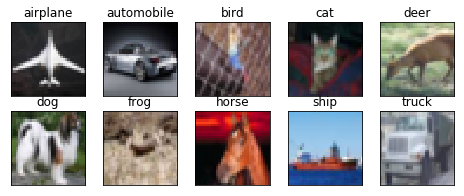

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# summarize dataset shape
print('Train', train_features.shape, train_labels.shape)
print('Test', (test_features.shape, test_labels.shape))
# summarize pixel values
print('Train', train_features.min(), train_features.max(), train_features.mean(), train_features.std())
print('Test', test_features.min(), test_features.max(), test_features.mean(), test_features.std())

Train (50000, 32, 32, 3) (50000, 10)
Test ((10000, 32, 32, 3), (10000, 10))
Train 0.0 1.0 0.4733649 0.25156906
Test 0.0 1.0 0.47658524 0.25121963


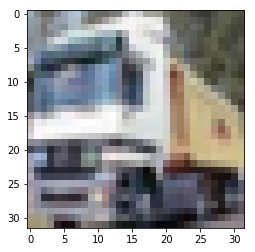

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(train_features[1])

#### Performing Image Normalization

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)


In [0]:
def space_to_depth_x2(y):
  return tf.space_to_depth(y, block_size=2)

In [0]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D, Flatten
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, merge, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D

In [0]:
import numpy as np
import tensorflow as tf

In [0]:
input_shape = (32,32)+(3,)

img_input = Input (shape = input_shape)


# Depthwise Separable Convolution
x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(img_input) #(5*5,32*32)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor1 = x

x = Conv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(9*9,32*32) of the form (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor2 = x

x = Conv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(13*13,32*32) of the form (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor3 = x

x = concatenate([skip_tensor1, x])

x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(17*17,32*32) of the form (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor4 = x

#-------------------------------------------------------
x = concatenate([skip_tensor1, x])

x =  MaxPooling2D(pool_size=(2,2),data_format='channels_last')(x) #(18*18,32*32) of the form  (effective global receptive field,output channel size )
#-------------------------------------------------------

x = SeparableConv2D(10,3,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(22*22,16*16) of the form  (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor5 = x

concat_1_4 = concatenate([skip_tensor1, skip_tensor4])#S
concat_1_4 = Lambda(space_to_depth_x2)(concat_1_4)
x = concatenate([concat_1_4, x])

x = Conv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(30*30,16*16) of the form (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor6 = x

concat_3_4 = concatenate([skip_tensor3, skip_tensor4])
concat_3_4 = Lambda(space_to_depth_x2)(concat_3_4)
x = concatenate([concat_3_4, skip_tensor5, x])

x = SeparableConv2D(10,3,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(34*34,16*16) of the form  (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor7 = x

concat_1_3_4 = concatenate([skip_tensor1, skip_tensor3, skip_tensor4])
concat_1_3_4 = Lambda(space_to_depth_x2)(concat_1_3_4)
x = concatenate([concat_1_3_4, skip_tensor5, skip_tensor6, x])

x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(42*42,16*16) of the form  (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor8 = x

#-------------------------------------------------------

x = concatenate([concat_1_4, skip_tensor5, skip_tensor7, x])

x =  MaxPooling2D(pool_size=(2,2),data_format='channels_last')(x)#(44*44,8*8) of the form  (effective global receptive field,output channel size )
#-------------------------------------------------------


concat_6 = Lambda(space_to_depth_x2)(skip_tensor6)
x = concatenate([concat_6, x])

x = Conv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(60*60,8*8) of the form  (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor9 = x

concat_2_4 = concatenate([skip_tensor2, skip_tensor4])
concat_2_4 = Lambda(space_to_depth_x2)(concat_2_4)
concat_2_4 = Lambda(space_to_depth_x2)(concat_2_4)
concat_7 = Lambda(space_to_depth_x2)(skip_tensor7)
x = concatenate([concat_2_4, concat_7, x])

x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(76*76,8*8) of the form  (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor10 = x

concat_2_3 = concatenate([skip_tensor2, skip_tensor3])
concat_2_3 = Lambda(space_to_depth_x2)(concat_2_3)
concat_2_3 = Lambda(space_to_depth_x2)(concat_2_3)
concat_5 = Lambda(space_to_depth_x2)(skip_tensor5)
x = concatenate([concat_2_3, concat_5, skip_tensor9, x])

x = Conv2D(10,3,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(84*84,8*8) of the form  (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor11 = x

concat_1_3_4 = concatenate([skip_tensor1, skip_tensor3, skip_tensor4])
concat_1_3_4 = Lambda(space_to_depth_x2)(concat_1_3_4)
concat_1_3_4 = Lambda(space_to_depth_x2)(concat_1_3_4)
concat_5_7 = concatenate([skip_tensor5, skip_tensor7])
concat_5_7 = Lambda(space_to_depth_x2)(concat_5_7)
x = concatenate([concat_1_3_4, concat_5_7, skip_tensor10, x])

x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(100*100,8*8) of the form  (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

concat_4 = Lambda(space_to_depth_x2)(skip_tensor4)
concat_4 = Lambda(space_to_depth_x2)(concat_4)
concat_7 = Lambda(space_to_depth_x2)(skip_tensor7)
x = concatenate([concat_4, concat_7, skip_tensor10, x])

x = Conv2D(10, 1,strides=1,data_format='channels_last',use_bias=False)(x) #(100*100,8*8) of the form  (effective global receptive field,output channel size )
x = GlobalAveragePooling2D(data_format= 'channels_last')(x)
#x = Flatten()(x)
output = Activation('softmax')(x)


In [0]:
model = Model(inputs=img_input, outputs=output)

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_25 (SeparableC (None, 32, 32, 10)   105         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 32, 32, 10)   40          separable_conv2d_25[0][0]        
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 32, 32, 10)   0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv2d_21 

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

In [0]:
# checkpoint
filepath="./Assignment6_21_2019-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,LearningRateScheduler(scheduler, verbose=1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 19s 49ms/step - loss: 1.5287 - acc: 0.4394 - val_loss: 1.6871 - val_acc: 0.4188

Epoch 00001: val_acc improved from -inf to 0.41880, saving model to ./Assignment6_21_2019-01-0.42.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 16s 41ms/step - loss: 1.1445 - acc: 0.5885 - val_loss: 1.5291 - val_acc: 0.4641

Epoch 00002: val_acc improved from 0.41880 to 0.46410, saving model to ./Assignment6_21_2019-02-0.46.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 16s 40ms/step - loss: 0.9740 - acc: 0.6538 - val_loss: 1.1948 - val_acc: 0.5841

Epoch 00003: val_acc improved from 0.46410 to 0.58410, saving model to ./Assignment6_21_2019-03-0.58.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate t

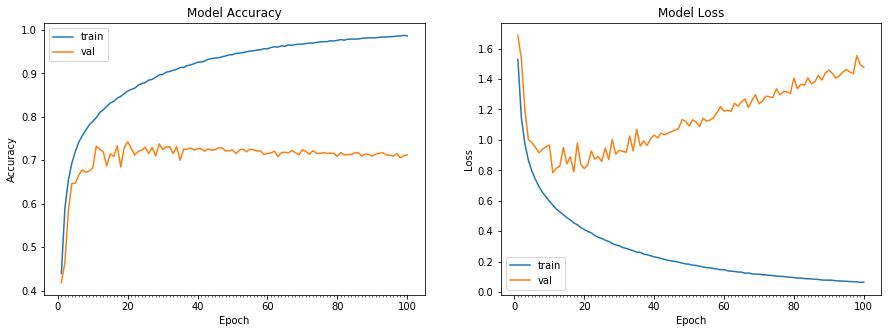

Accuracy on test data is: 71.23


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,data_format='channels_last')


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks = callbacks_list )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))